In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import numpy as np
from tensorflow.keras import layers 


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from PIL import Image, ImageFile

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

First we load in the dataset and use ImageDataGenerator to split it into batches

In [4]:
file = r'F:\Verona\Computer_Vision_and_Deep_Learning\Project\kagglecatsanddogs_5340\PetImages'
test_dir = r'F:\Verona\Computer_Vision_and_Deep_Learning\Project\archive\test'
train_dir = r'F:\Verona\Computer_Vision_and_Deep_Learning\Project\archive\train'

In [5]:
data_dir = pathlib.Path("./cats-and-dogs-image-classification")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data = train_datagen.flow_from_directory(
    directory=str(train_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Or 'binary' based on your dataset
)
test_data = test_datagen.flow_from_directory(
    directory=str(test_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Or 'binary' based on your dataset
)

Found 557 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


Confusion Matrix

In [6]:
y_true = [0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 1, 0, 0, 1, 1, 1, 0]

In [7]:
cm = confusion_matrix(y_true, y_pred)

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


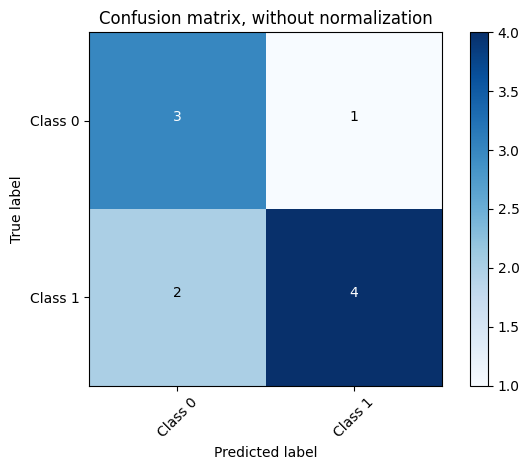

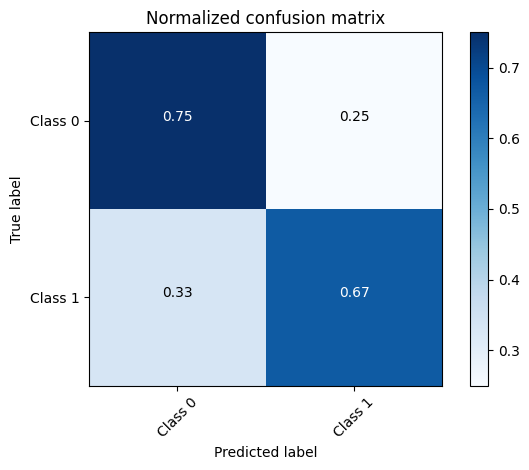

In [9]:
# Define class labels (if applicable)
class_names = ['Class 0', 'Class 1']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [10]:
image_shape = (224, 224)

Now importing ResNet50V2 from TF-Hub

In [11]:
def create_model(model_url, num_classes):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name="feature_extractor_layer",
        input_shape=image_shape + (3,)
    )  # freeze pre-learned patterns
    
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=image_shape + (3,)),
        tf.keras.layers.Lambda(lambda x: feature_extractor_layer(x)),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    return model

In [12]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
num_classes = train_data.num_classes  # Ensure train_data is properly initialized
model = create_model(resnet_url, num_classes)

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098 (16.01 KB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
base_dir = pathlib.Path("F:/Verona/Computer_Vision_and_Deep_Learning/Project/cats-and-dogs-image-classification")
train_dir = base_dir / "train"
test_dir = base_dir / "test"

In [16]:
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except (IOError, SyntaxError, ValueError):
        return False

In [17]:
train_files = [file for file in train_dir.rglob('*.*') if is_valid_image(file)]
test_files = [file for file in test_dir.rglob('*.*') if is_valid_image(file)]

In [18]:
import shutil
import tempfile

def copy_files(files, target_dir):
    for file in files:
        relative_path = file.relative_to(file.parents[2])  # Maintain the subdirectory structure
        target_path = target_dir / relative_path
        target_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(file, target_path)

with tempfile.TemporaryDirectory() as tmp_train_dir, tempfile.TemporaryDirectory() as tmp_test_dir:
    tmp_train_path = pathlib.Path(tmp_train_dir)
    tmp_test_path = pathlib.Path(tmp_test_dir)
    copy_files(train_files, tmp_train_path)
    copy_files(test_files, tmp_test_path)

    # Data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_data = train_datagen.flow_from_directory(
        directory=str(tmp_train_path),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    test_data = test_datagen.flow_from_directory(
        directory=str(tmp_test_path),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )

    # Model definition
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Fit model
    history = model.fit(
        train_data,
        epochs=10,
        steps_per_epoch=train_data.samples // train_data.batch_size,
        validation_data=test_data,
        validation_steps=test_data.samples // test_data.batch_size
    )


Found 557 images belonging to 1 classes.
Found 140 images belonging to 1 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9756 - loss: 0.1199 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 891ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 879ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 833ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 

CNN

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir(r'F:\Verona\Computer_Vision_and_Deep_Learning\Project\kagglecatsanddogs_5340\PetImages')
os.listdir()

['Cat', 'Dog']

In [20]:
import tensorflow as tf
from tensorflow import keras
print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Tensorflow Version: 2.16.1
Number of GPUs Available: 0


In [21]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


Generating Data

In [22]:
train_dir = r'F:\Verona\Computer_Vision_and_Deep_Learning\Project\archive\test'
test_dir = r'F:\Verona\Computer_Vision_and_Deep_Learning\Project\archive\train'

In [23]:
from keras.utils import image_dataset_from_directory
train_generator = image_dataset_from_directory(train_dir, image_size=(64, 64), batch_size=32)
test_generator = image_dataset_from_directory(test_dir, image_size=(64, 64), batch_size=32)

Found 140 files belonging to 2 classes.
Found 557 files belonging to 2 classes.


Data Visualization

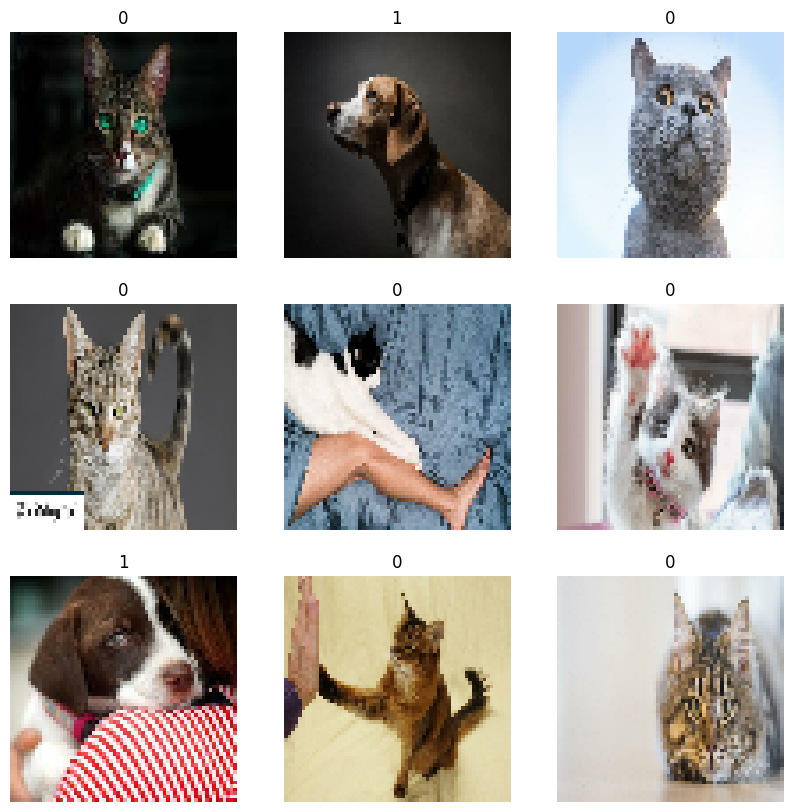

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_generator:
    for i in range(min(9, len(images))):
        try:
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        except Exception as e:
            print(f"Error with image {i}: {e}")
            continue
    break
plt.show()

Building Neural Network

In [25]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    # Conv layer 1:
    keras.layers.Conv2D(128, (3, 3), input_shape=(64,64,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv layer 2:
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv layer 3:
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    
    # Fully connected layers:
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,449 (954.88 KB)

 Trainable params: 244,001 (953.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
pip install --upgrade visualkeras

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Visualize the model architecture in 2D
plot_model(model, to_file='model.png', show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
red_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1)
logs = model.fit(train_generator, epochs=50, validation_data=test_generator,validation_steps=2000/32, callbacks=[es, red_lr])

Plotting Training curve:

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Log')
plt.plot(logs.history['loss'], label='Training Loss')
plt.plot(logs.history['accuracy'], label='Training Accuracy')
# plt.plot(logs.history['val_loss'], label='Validation Loss', linewidth=3)
# plt.plot(logs.history['val_accuracy'], label='Validation accuracy', linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

Model Evaluation

In [ ]:
res = model.evaluate(test_generator)

In [ ]:
accuracy = res[1]
print(accuracy)

Tesing a random image:

In [ ]:
img = keras.preprocessing.image.load_img(
    "/kaggle/input/cats-and-dogs-image-classification/train/cats/cat_104.jpg", 
    target_size=(64,64)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")